# BI8040-Logical Modeling for Experimental Design in Biotechnology and Biomedicine, NTNU

## Corinna Dannert & Yitong Sun
### August, 2020

## Apoptosis and Cell Fate Model

The mechanisms by which a cell chooses whether it will start apoptosis, necrosis (or other non apoptotic cell deaths) or whether it will continue surviving are still unclear. Therefore, a logical model simulating the regulatory network controlling the cell-fate can help increase the understanding of these mechanisms. 

In this project, we analyzed the model designed by Calzone *et al.*: Mathematical Modelling of Cell-Fate Decision in Response to Death Receptor Engagement. 

The aim of this project is to (1)obtain knowlegde about reproducible results under the same docker environment and (2)perform logical modelling analysis enabled by various software tools.

For the reproducible purpose, given that Docker and Pyhton are installed, this notebook can be executed using command line:
```
colomoto-docker -V 2020-08-01
```

For the model analysis part, all the software tools used in this notebook are listed in *Table 1*.

**Table 1** List of software tools used in this notebook

_|Tool   |Website |  Feature executed
:----     |:------ | :----------------------------- | :------------------------------------------------------------
1|GINsim | [ginsim.org](http://ginsim.org) | Model import and visualization, conversion to bioLQM and Pint
2|bioLQM | [colomoto.org/biolqm](http://colomoto.org/biolqm) | Trapspaces and fixpoint computation, conversion to MaBoSS
3|Pint   | [loicpauleve.name/pint](http://loicpauleve.name/pint) | Transient reachability analysis, mutation prediction, conversion to NuSMV
4|NuSMV  | [nusmv.fbk.eu](http://nusmv.fbk.eu) | Phenotype reachability checking
5|MaBoSS | [maboss.curie.fr](https://maboss.curie.fr) | Stochastic simulations, reachability analysis of certain phenotypes under different mutations


Our work flow can be described as below and shown in the figure`Out[1]`:

**On the master model:**

       (1) GINsim model importing and visualization.
       (2) Trapspaces and fixpoint computation, perturbation analysis using BioLQM.
       (3) Model checking with NuSMV.
       (4) Goal reachability analysis, mutation prediction with Pint.
       (5) Stochastic simulations, reachability analysis using MaBoSS.

**On the reduced model:**

       (1) GINsim model reduction, attractor analysis.
       (2) MaBoSS simulations on wild-type model.

In [1]:
from IPython.display import Image
Image(url = "https://raw.githubusercontent.com/yitong-sun/BI8040_2020/master/workflow.jpg")

# Highlight  --- Content you can find in this project

### Master model:

#### Wild-type model
    - GINsim, model loading and visualization
    - bioLQM, attractor analysis
    - Pint,   reachability analysis  (TNF=0,FAS=0)&(TNF=1,FAS=0)
    - NuSMV,  model checking         (TNF=0,FAS=0)&(TNF=1,FAS=0)
    - MaBoSS, stochastic simulation  (TNF=0,FAS=0)&(TNF=1,FAS=0)
    (The above three all get the same results when using different tools)

#### Single mutation perturbation, from paper
    - bioLQM, results displayed on heatmap
    - MaBoSS, results shown in pie charts and trajectory plots

#### Double mutation prediction, new insight explored
    - Pint, formal mutation prediction
    - MaBoSS, confirm simulation result above


### Reduced model:

#### Wild-type model
    - Attractor analysis
    - MaBoSS reachability analysis,
      same as that of the master model, which is indicated in the paper.

## Modules Importing and Model Loading

In [2]:
import ginsim
import biolqm
import maboss
import sys
import pypint
import pandas as pd
import seaborn as sns
from pypint import Goal
from colomoto.temporal_logics import *
from colomoto_jupyter import tabulate # for results table display
from itertools import combinations  # for iterating over sets
import matplotlib.pyplot as plt # for modifying plots
plt.rcParams.update({'figure.max_open_warning': 0}) # supress warnings when plotting too many piecharts

This notebook has been executed using the docker image `colomoto/colomoto-docker:2020-08-01`

In [3]:
# Loading the apoptosis model from Calzone et al.
model_ginsim=ginsim.load("http://ginsim.org/sites/default/files/Calzone__Cell_Fate.zginml")
ginsim.show(model_ginsim)

Downloading http://ginsim.org/sites/default/files/Calzone__Cell_Fate.zginml

The model is online available at GINsim model repository: 
[http://ginsim.org/models_repository](http://ginsim.org/models_repository).

In this regulatory network, three input nodes trigger the death receptor signals and three output nodes correspondents to three cross-talk pathways namely "NFkB pro-survival pathway"---`Survival`, "RIP1-dependent necrosis"---`NonACD`, "Caspase-dependent apoptosis"---`Apoptosis`. Edges are annotated with Boolean formalism, presenting here red as inhibiton and green for activation.

## Model Conversion Summay

In [4]:
# Converting the model to biolqm, maboss, pint and nusmv for further analysis

model_biolqm = ginsim.to_biolqm(model_ginsim) # convert to biolqm
model_maboss = biolqm.to_maboss(model_biolqm) # convert to maboss
model_pint = ginsim.to_pint(model_ginsim) # convert to pint
model_nusmv= model_pint.to_nusmv() # convert to nusmv

## Computation of Stable States using bioLQM

First we performed the trapsapces analysis to identify the attractors. 


The result shows 27 trapspaces (stable motifs), each row is associated with one phenotype as survival(`Survival`=1), apoptosis(`Apoptosis`=1), necrosis(`NonACD`=1), and when none of the output nodes equal to value 1, the cells stay in ‘‘na ̈ıve’’ state state.

In [5]:
# Trapspaces analysis with the wild-type model
traps = biolqm.trapspace(model_biolqm)
tabulate(traps)

,FASL,TNF,TNFR,DISC_TNF,DISC_FAS,FADD,RIP1,RIP1ub,RIP1K,IKK,NFkB,CASP8,BAX,BCL2,ROS,ATP,MPT,MOMP,SMAC,cIAP,Cyt_c,XIAP,apoptosome,CASP3,cFLIP,NonACD,Apoptosis,Survival
18,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
14,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0
10,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,1,1,0,1,0,0,0,0,1,0,0
2,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,0,1,1,0,1,0,1,1,0,0,1,0
17,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
15,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0
12,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,1,1,0,1,0,0,0,0,1,0,0
6,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,1,0,1,1,0,1,0,1,1,0,0,1,0
3,0,1,1,0,0,0,0,0,0,0,0,1,1,0,0,1,0,1,1,0,1,0,1,1,0,0,1,0
24,0,1,1,0,0,0,1,0,1,0,0,0,0,0,1,0,1,1,1,0,1,0,0,0,0,1,0,0


Then stable states (fixpoints) are computed and displayed in table fromat. We have 27 fixpoints calculated as the same in the paper. Worth mentioning is that the same result from trapspaces and fixpoints analysis indicate that no cyclical attractor is found in our model.

In [6]:
fps = biolqm.fixpoints(model_biolqm) # calculate fixpoints
print(len(fps), "fixpoints") # shows the number of fixpoints
tabulate(fps) # table displaying all the fixpoints

27 fixpoints


,FASL,TNF,TNFR,DISC_TNF,DISC_FAS,FADD,RIP1,RIP1ub,RIP1K,IKK,NFkB,CASP8,BAX,BCL2,ROS,ATP,MPT,MOMP,SMAC,cIAP,Cyt_c,XIAP,apoptosome,CASP3,cFLIP,NonACD,Apoptosis,Survival
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,1,1,0,1,0,0,0,0,1,0,0
6,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,0,1,1,0,1,0,1,1,0,0,1,0
1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0
5,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,1,1,0,1,0,0,0,0,1,0,0
7,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,1,0,1,1,0,1,0,1,1,0,0,1,0
8,0,1,1,0,0,0,0,0,0,0,0,1,1,0,0,1,0,1,1,0,1,0,1,1,0,0,1,0
9,0,1,1,0,0,0,1,0,1,0,0,0,0,0,1,0,1,1,1,0,1,0,0,0,0,1,0,0


The fixed points can be visualized and here we show the number 11 fixpoint for example.

In [7]:
ginsim.show(model_ginsim, fps[11]) #show specific fixpoint (here number 11)

# Assessment of Reachability using Pint

Given the initial state from the paper, input nodes death receptor TNF=1, FAS=0; intermediate nodes cIAP=1, ATP=1; and FADD=1 always ON which complies with the required conditions stated in the paper. Here we have all nodes with value 1 shown below.

In [8]:
# setting the initial state
model_pint_TNF_on = model_pint.having({"TNF": 1, "FASL": 0, "cIAP": 1, "ATP": 1, "FADD": 1})
model_pint_TNF_on.initial_state.nonzeros() # shows the inital states that have a value other than 0


#model_pint_TNF_on.summary() # shows the basic statistics of the model
#model_pint_TNF_on.automata
#model_pint_TNF_on.local_states # list of all the local states
#model_pint_TNF_on.local_transitions # list of all the local transitions

{'TNF': 1, 'FADD': 1, 'ATP': 1, 'cIAP': 1}

After the computation od attractors, we would like to test the reachability of attractors to a goal state, which means `Survival`, `NonACD` and `Apoptosis`.

For this wild-type model, we performed the analysis under two inital conditions:
```
(1)TNF=1 and FAS=0, leading to ALL TRUE in three states that possible to reach.
(2)TNF=0 and FAS=0, leading to ALL FALSE so that cells stay at naive state.
```

With FADD always ON as it is throughout this project.

In [9]:
# Assess the reachability of a goal using pint (transient reachability analysis, goal does not have to be a stable state)
Survival= Goal("Survival=1")
Apoptosis = Goal("Apoptosis=1")
NonACD = Goal("NonACD=1")

goals=["Survival", "Apoptosis", "NonACD"]
model_pint_list={}


# For the inital condition: TNF=1 and FAS=0
print(model_pint.having({"TNF": 1, "FASL": 0, "FADD": 1, "ATP": 1, "cIAP": 1}).reachability("Survival=1"))

print(model_pint.having({"TNF": 1, "FASL": 0, "FADD": 1, "ATP": 1, "cIAP": 1}).reachability("Apoptosis=1"))

print(model_pint.having({"TNF": 1, "FASL": 0, "FADD": 1, "ATP": 1, "cIAP": 1}).reachability("NonACD=1"))


# For the initial condition: TNF=0 and FAS=0
print(model_pint.having({"TNF": 0, "FASL": 0, "FADD": 1, "ATP": 1, "cIAP": 1}).reachability("Survival=1"))

print(model_pint.having({"TNF": 0, "FASL": 0, "FADD": 1, "ATP": 1, "cIAP": 1}).reachability("Apoptosis=1"))

print(model_pint.having({"TNF": 0, "FASL": 0, "FADD": 1, "ATP": 1, "cIAP": 1}).reachability("NonACD=1"))


True
True
True
False
False
False


Then, we reproduce the same results using NuSMV model checking function.

# Model Checking using NuSMV

Here we also start from the initial conditions:
```
(1)TNF=1 and FAS=0
(2)TNF=0 and FAS=0
```  
getting the same results as `Out [9]` in the output below. When TNF is ON and FAS is OFF, all three phenotype can be reached, while both TNF and FAS are OFF, none phenotype can be reached thus end at naive state.

In [10]:
#from colomoto.temporal_logics import *
# intial state with TNF=1 and FAS=0. 

initial_state = S(FASL=0,FADD=1,TNF=1,TNFR=0,DISC_TNF=0,DISC_FAS=0,RIP1=0,RIP1ub=0,RIP1K=0,IKK=0,NFkB=0,CASP8=0,BAX=0,BCL2=0,ROS=0,ATP=1,MPT=0,MOMP=0,SMAC=0,cIAP=1,Cyt_c=0,XIAP=0,apoptosome=0,CASP3=0,cFLIP=0,NonACD=0,Apoptosis=0,Survival=0)

survival = AG(S(Survival=1,FADD=1))
nonACD = AG(S(NonACD=1,FADD=1))
apoptosis = AG(S(Apoptosis=1,FADD=1))
# add multiple stable states
specs = {
    "reach_survival": If(initial_state,EF(survival)),
    "reach_nonacd": If(initial_state,EF(nonACD)),
    "reach_apoptosis": If(initial_state,EF(apoptosis))
}

model_nusmv.add_ctls(specs)
model_nusmv.verify()

{'reach_survival': True, 'reach_nonacd': True, 'reach_apoptosis': True}

In [11]:
# initial condition TNF=0, FAS=0

model_nusmv= model_pint.to_nusmv() # convert to nusmv

initial_state = S(FASL=0,FADD=1,TNF=0,TNFR=0,DISC_TNF=0,DISC_FAS=0,RIP1=0,RIP1ub=0,RIP1K=0,IKK=0,NFkB=0,CASP8=0,BAX=0,BCL2=0,ROS=0,ATP=1,MPT=0,MOMP=0,SMAC=0,cIAP=1,Cyt_c=0,XIAP=0,apoptosome=0,CASP3=0,cFLIP=0,NonACD=0,Apoptosis=0,Survival=0)
#initial_state = S(FASL=0,FADD=1,TNF=1,ATP=1,cIAP=1) #define the initial states
survival = AG(S(Survival=1,FADD=1))
nonACD = AG(S(NonACD=1,FADD=1))
apoptosis = AG(S(Apoptosis=1,FADD=1))
# add multiple stable states
specs = {
    "reach_survival": If(initial_state,EF(survival)),
    "reach_nonacd": If(initial_state,EF(nonACD)),
    "reach_apoptosis": If(initial_state,EF(apoptosis))
}

model_nusmv.add_ctls(specs)
model_nusmv.verify()

{'reach_survival': False, 'reach_nonacd': False, 'reach_apoptosis': False}

# Assessment of Reachability using MaBoSS

## Simulation parameters

Among the parameter list, sample_count corresponds to the number of simulations performed to compute statistics, while max_time is the maximum (simulated) duration of a trajectory. Note that for a proper estimation of probabilities of the stable states, max_time needs to be long enough for the simulation to reach an asymptotic solution.

*(Here we used the same parameters as in the example)*
## Initial States
Here we will calculate whether the stable states `Survival`, `NonACD` and `Apoptosis` can be reached when starting from a specific set of initial states. 

We focus on TNF and FAS proteins since they can trigger cell death. 

Therefore, we start with setting the intial states for MaBoSS simulation.

In [12]:
model_maboss.update_parameters(discrete_time=0, use_physrandgen=0,
        seed_pseudorandom=100, sample_count=10000,
        max_time=75, time_tick=0.1, thread_count=4,
        statdist_traj_count=100, statdist_cluster_threshold=0.9)

Choosing the output nodes, here `Survival`, `NonACD` and `Apoptosis`.


In [13]:
#maboss.wg_set_output(model_maboss)
#maboss.set_output(model_maboss, ["NonACD","Survival", "Apoptosis"])
model_maboss.network.set_output(('Apoptosis','Survival','NonACD'))

The resulting object gives access to the output data generated by MaBoSS. It includes notably the mean probability over time for the activity of the output states integrated over all the performed simulations.


## MaBoSS simulation of the wild-type model

The object model_maboss represents the input of MaBoSS, encompassing both the network and simulation parameters. The simulations are triggered with the .run() method and return a Python object for accessing the results.

Here we have the result as ALL phenotypes can be reached in ```Out[14]```, which comply with that ALL TRUE results from Pint and NuSMV.

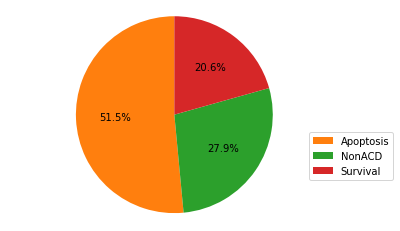

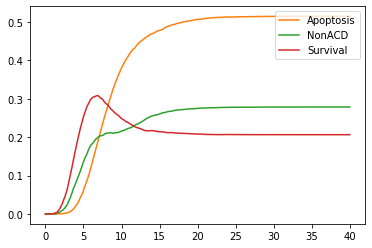

In [14]:
# initial state TNF=1 and FAS=0
maboss_2 = model_maboss.copy()
maboss_2.network.set_istate('TNF', [0,1])
maboss_2.network.set_istate('FASL', [1,0])
maboss.set_nodes_istate(maboss_2, ["ATP", "cIAP", "FADD"], [0,1])
#print(maboss_2.get_initial_state())

# Perform the simulation
result = maboss_2.run()
result.plot_piechart()
result.plot_node_trajectory(until=40)

At initial state TNF=FAS=0, with ALL FALSE results from previous analysis using Pint and NuSMV, below we get the pie chart as null because none of the three cell fate can be reached. 

{'FASL': 0, 'TNF': 0, 'TNFR': 0, 'DISC_TNF': 0, 'DISC_FAS': 0, 'FADD': 1, 'RIP1': 0, 'RIP1ub': 0, 'RIP1K': 0, 'IKK': 0, 'NFkB': 0, 'CASP8': 0, 'BAX': 0, 'BCL2': 0, 'ROS': 0, 'ATP': 1, 'MPT': 0, 'MOMP': 0, 'SMAC': 0, 'cIAP': 1, 'Cyt_c': 0, 'XIAP': 0, 'apoptosome': 0, 'CASP3': 0, 'cFLIP': 0, 'NonACD': 0, 'Apoptosis': 0, 'Survival': 0}


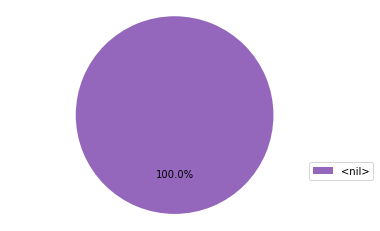

In [15]:
##initial state TNF=FAS=0
maboss_1 = model_maboss.copy()
maboss.set_nodes_istate(maboss_1, ["ATP", "cIAP", "FADD"], [0,1])
maboss.set_nodes_istate(maboss_1, ["TNF", "FASL"], [1,0])

print(maboss_1.get_initial_state())

# Perform the simulation
result = maboss_1.run()
result.plot_piechart()
#result.plot_node_trajectory(until=40)

Next, we ran all the perturbations under mutated conditions specified in the paper. The results are shown the the heatmap with all reachable stable states displayed.

**How to describe this heatmap????**

# Single mutation perturbation, from paper

## bioLQM with heatmap display

The single mutation perturbation analysis using bioLQM shows all reachable stable states of the master model. Under the condition that each node knock-down (OFF) or over-expression (ON).

Text(0.5, 0.98, 'Clustered heatmap of each stable states found for each perturbation')

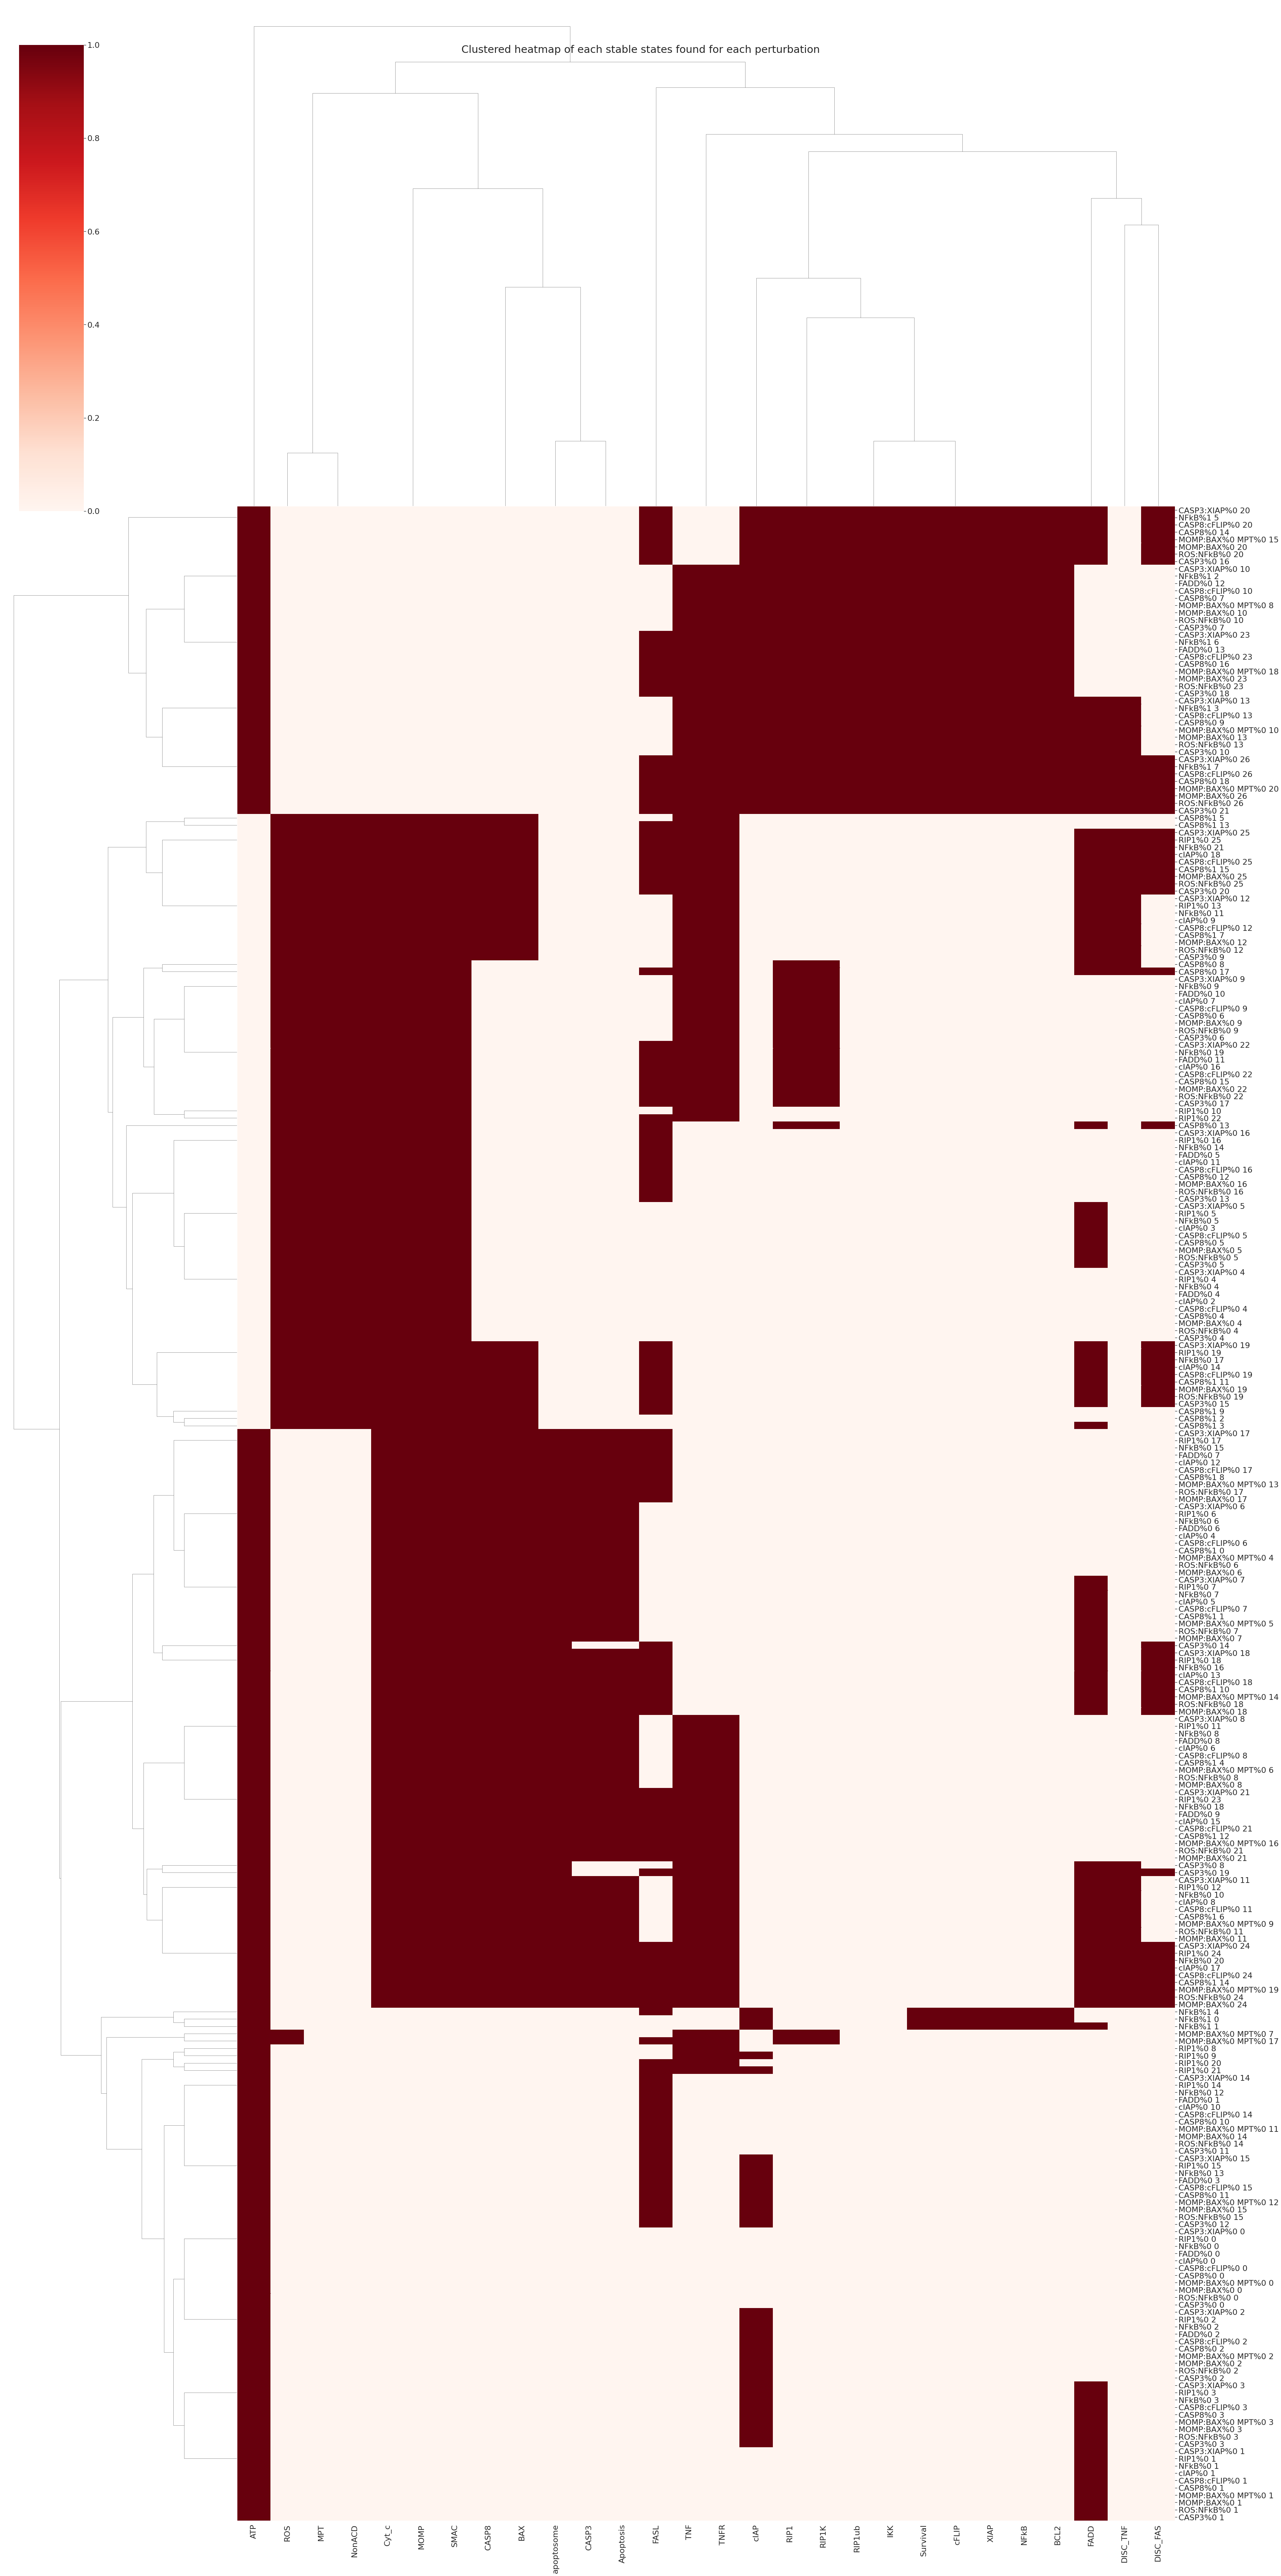

In [27]:
perturbations = ["ROS:NFkB%0",
                 "CASP3%0", 
                 "MOMP:BAX%0",
                 "MOMP:BAX%0 MPT%0",
                 "CASP8%0", 
                 "CASP8%1", 
                 "CASP8:cFLIP%0",
                 "cIAP%0",
                 "FADD%0", 
                 "NFkB%0",
                 "NFkB%1", 
                 "RIP1%0", 
                 "CASP3:XIAP%0",
                 #"CASP3%0 CASP8%0 RIP1%0"
                ]


# Define dictionaries to store attractors for each perturbation
fixpointlist = {}

# trapspacelist is used for perturbations where no stable state is found to find eventual cyclic attractors.
trapspacelist = {}

for p in perturbations:
    fixpoints = biolqm.fixpoints(biolqm.perturbation(model_biolqm, p))
    if(fixpoints):
        fixpointlist[p] = fixpoints
    else:
        # No stable state found, so we look for cycles
        trapspace = biolqm.trapspace(biolqm.perturbation(model_biolqm, p))
        trapspacelist[p] = trapspace


# List of perturbations with the nb of stable states 
perturbstates=[]
trappedstates=[]

# List of table state values same order as perturbStates
stablestates = [] 
tstates = [] 

#List of nodes
nodelist = ['FASL', 'TNF', 'TNFR', 'DISC_TNF', 'DISC_FAS', 'FADD', 'RIP1', 'RIP1ub', 'RIP1K', 'IKK', 'NFkB', 'CASP8', 'BAX', 'BCL2', 'ROS', 'ATP', 'MPT', 'MOMP', 'SMAC', 'cIAP', 'Cyt_c', 'XIAP', 'apoptosome', 'CASP3', 'cFLIP', 'NonACD', 'Apoptosis', 'Survival']

for k,v in fixpointlist.items():   
    for i in range(0,len(v)):
        listSS = []
        for key, val in v[i].items():
            listSS.append(val)
        stablestates.append(listSS)
        perturbstates.append(str(k)+' '+str(i))

# Create dataframe: columns = nodes, rows = perturbations
df = pd.DataFrame(data=stablestates)
df.columns = nodelist
df.index = perturbstates

# Generate clustered heatmap
sns.set(font_scale=2)
cm = sns.clustermap(df, metric='euclidean', cmap = 'Reds', yticklabels=True, figsize=(50, 100))
cm.fig.suptitle('Clustered heatmap of each stable states found for each perturbation')

## MaBoSS simulation with pie charts and trajectory plots

Here we mutate some of the proteins to see if the reachability of apoptosis changes. 
Therefore, the GINsim model was modified to include different mutations via modified rules (see table 2 in the article).


**need some discussion on the pie chart**




{'ROS:NFkB%0': <maboss.simulation.Simulation object at 0x7fb38abf35b0>, 'CASP3%0': <maboss.simulation.Simulation object at 0x7fb38ab48c40>, 'MOMP:BAX%0': <maboss.simulation.Simulation object at 0x7fb3979a4910>, 'MOMP:BAX%0 MPT%0': <maboss.simulation.Simulation object at 0x7fb39789eee0>, 'CASP8%0': <maboss.simulation.Simulation object at 0x7fb3b2368be0>, 'CASP8%1': <maboss.simulation.Simulation object at 0x7fb3978fd5e0>, 'CASP8:cFLIP%0': <maboss.simulation.Simulation object at 0x7fb3a3addfd0>, 'cIAP%0': <maboss.simulation.Simulation object at 0x7fb397c082b0>, 'FADD%0': <maboss.simulation.Simulation object at 0x7fb397adac70>, 'NFkB%0': <maboss.simulation.Simulation object at 0x7fb39785b9d0>, 'NFkB%1': <maboss.simulation.Simulation object at 0x7fb38ab48490>, 'RIP1%0': <maboss.simulation.Simulation object at 0x7fb3a3a8e070>, 'CASP3:XIAP%0': <maboss.simulation.Simulation object at 0x7fb3b1f77520>}


/opt/conda/lib/python3.8/site-packages/maboss/figures.py:86: MatplotlibDeprecationWarning: normalize=None does not normalize if the sum is less than 1 but this behavior is deprecated since 3.3 until two minor releases later. After the deprecation period the default value will be normalize=True. To prevent normalization pass normalize=False 
  ax.pie(plot_line, labels=plotting_labels, radius=1.2,


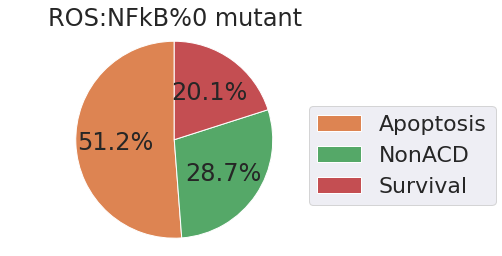

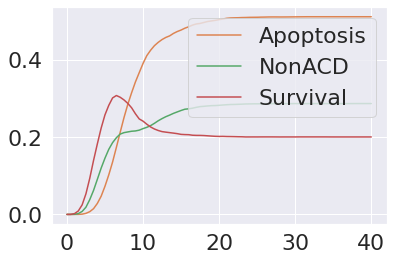

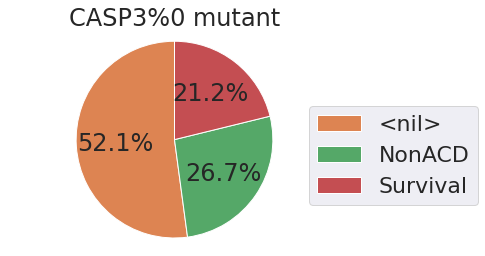

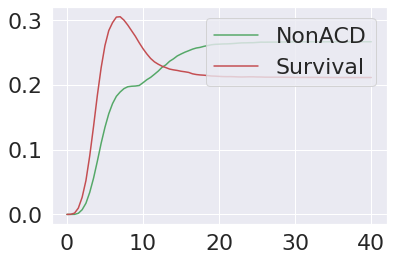

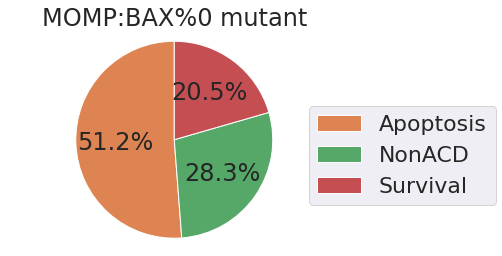

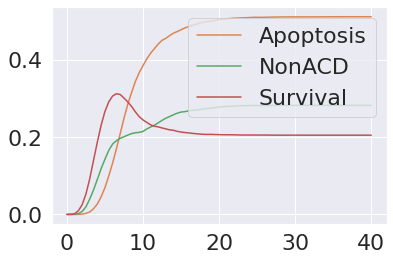

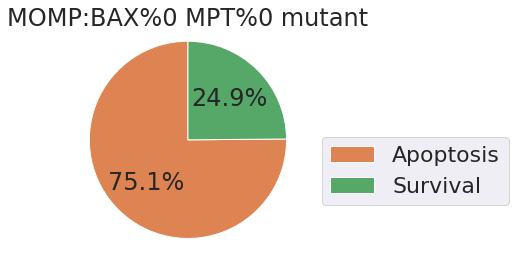

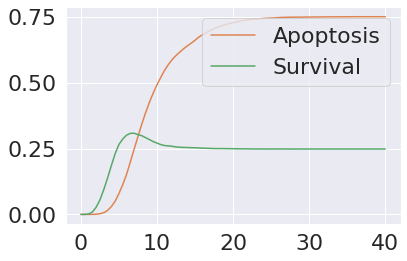

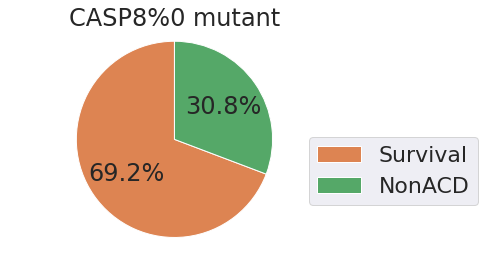

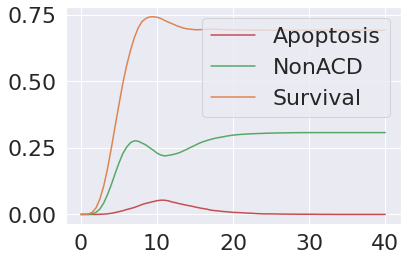

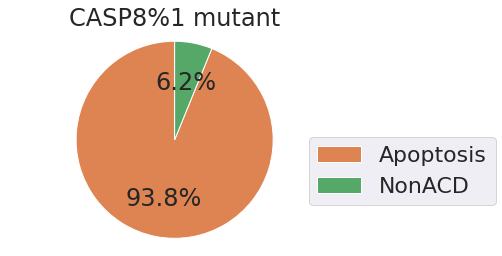

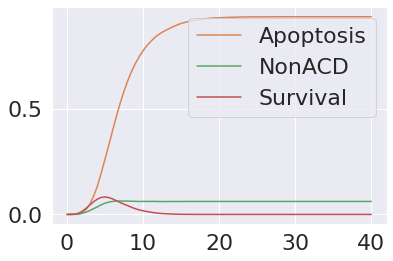

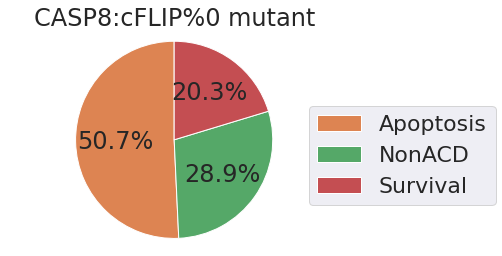

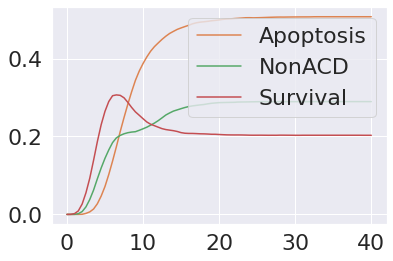

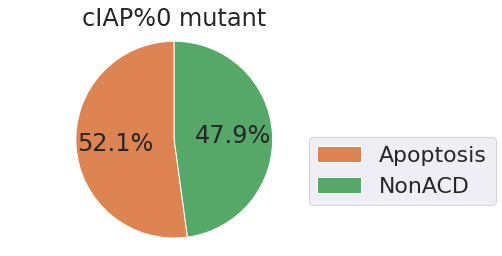

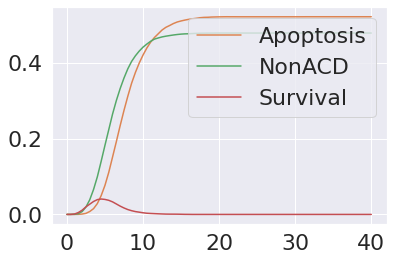

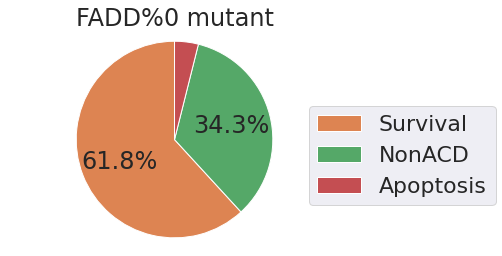

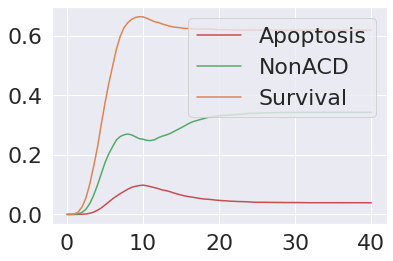

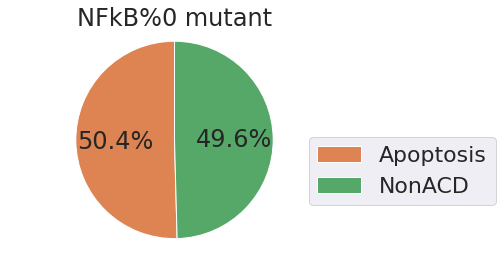

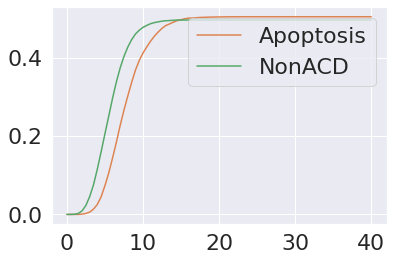

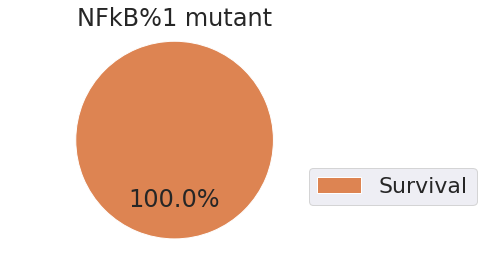

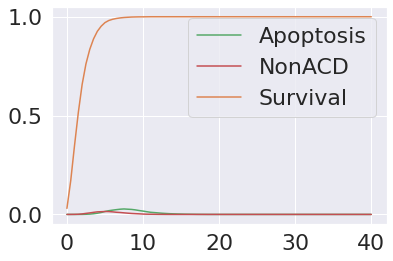

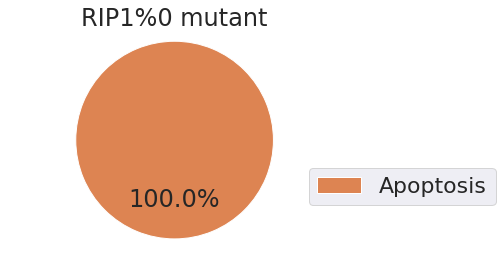

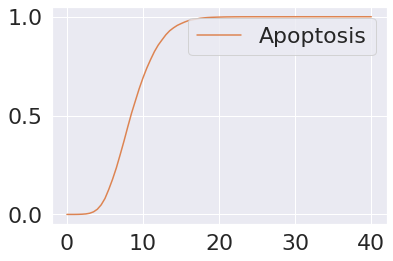

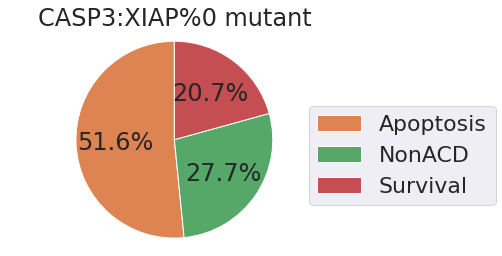

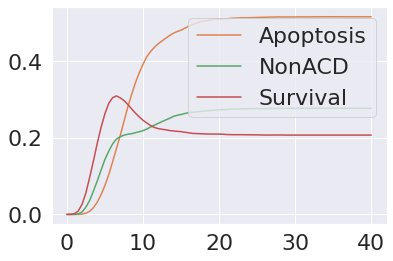

In [29]:
import matplotlib.pyplot as plt

perturbations = ["ROS:NFkB%0",
                 "CASP3%0", 
                 "MOMP:BAX%0",
                 "MOMP:BAX%0 MPT%0",
                 "CASP8%0", 
                 "CASP8%1", 
                 "CASP8:cFLIP%0",
                 "cIAP%0",
                 "FADD%0", 
                 "NFkB%0",
                 "NFkB%1", 
                 "RIP1%0", 
                 "CASP3:XIAP%0",
                 #"CASP3%0 CASP8%0 RIP1%0"
                ]


# Define dictionaries to store attractors for each perturbation
fixpointlist = {}

# trapspacelist is used for perturbations where no stable state is found to find eventual cyclic attractors.
trapspacelist = {}

for p in perturbations:
    fixpoints = biolqm.fixpoints(biolqm.perturbation(model_biolqm, p))
    if(fixpoints):
        fixpointlist[p] = fixpoints
    else:
        # No stable state found, so we look for cycles
        trapspace = biolqm.trapspace(biolqm.perturbation(model_biolqm, p))
        trapspacelist[p] = trapspace
'''
# uncomment to see attractors in tabulated tables for each perturbation
for k, v in fixpointlist.items():
    print(k)
    sys.displayhook(tabulate(v))
    print()
    
for k, v in trapspacelist.items():
    print(k)
    sys.displayhook(tabulate(v))
    print() 

'''
# list to store perturbed models
mut_biolqm_list = {}
mut_maboss_list = {}


for p in perturbations:
    mut_maboss = biolqm.to_maboss(biolqm.perturbation(model_biolqm, p))
    mut_maboss.network.set_output(('Apoptosis','Survival','NonACD'))    
    maboss.set_nodes_istate(mut_maboss, ["ATP", "cIAP", "FADD"], [0,1])
    mut_maboss.network.set_istate('TNF', [0,1])
    mut_maboss.network.set_istate('FASL', [1,0])

   # mut_biolqm_list[p]=mut_biolqm
    mut_maboss_list[p] = mut_maboss
print(mut_maboss_list)


for p in mut_maboss_list:
    result = mut_maboss_list[p].run()
    result.plot_piechart()
    name = p
    plt.title("%s mutant" % name)
    if (result):
        result.plot_node_trajectory(until=40)

# Double mutation prediction, new insight explored

## Pint, formal mutation prediction

Starting from the goal reachability identification purpose, we use Pint to formally predict the mutations that prevent cell fate ```Survival``` and ```NonACD```. We hope to identify the mutation type that leads to ```Apoptosis```, which could be potential drug targets that trigger apoptosis in cancer cells.

Initial condition settings remain the same with TNF=1, FAS=0.

In [16]:
#TNF=1, FAS=0
#pint

goal = Goal("NonACD=1") | Goal("Survival=1")

model_pint.initial_state["TNF"] = 1
model_pint.initial_state["FASL"] = 0
model_pint.initial_state["FADD"] = 1
model_pint.initial_state["ATP"] = 1
model_pint.initial_state["cIAP"] = 1

mutations = model_pint.oneshot_mutations_for_cut(goal, maxsize=1, exclude={"TNF","FASL", "FADD"})
mutations


This computation is an *under-approximation*: returned mutations are all valid, but they may be non-minimal, and some solutions may be missed.

Limiting solutions to mutations of at most 1 automata. Use `maxsize` argument to change.

[{'TNFR': 0}, {'RIP1': 0}, {'CASP8': 1}]

First we tested single mutation prediction and results in ```Out[16]``` gives reasonable output. Together with the regulatory graph of our model, TNFR OFF means no activation of the downstream node RIP1, both involoved in Survival pathway and NonACD pathway, thus prevent reaching the cell fate ```Survival``` and ```NonACD```. Besides, CASP8 is predicted to be ON since it plays a critical role in the activation of Caspase-dependent apoptosis phenotype.

Then, we manipulate the parameter ```maxsize```= 2 to get double mutations, shown in ```Out[17]```.

In [17]:
#maxsize manipulation

mutations2 = model_pint.oneshot_mutations_for_cut(goal, maxsize=2, exclude={"TNF","FASL", "FADD"})
mutations2

This computation is an *under-approximation*: returned mutations are all valid, but they may be non-minimal, and some solutions may be missed.

Limiting solutions to mutations of at most 2 automata. Use `maxsize` argument to change.

[{'TNFR': 0},
 {'RIP1': 0},
 {'CASP8': 1},
 {'RIP1ub': 0, 'RIP1K': 0},
 {'RIP1ub': 0, 'BCL2': 1},
 {'RIP1ub': 0, 'ROS': 0},
 {'RIP1ub': 0, 'ATP': 1},
 {'RIP1ub': 0, 'MPT': 0},
 {'RIP1K': 0, 'IKK': 0},
 {'RIP1K': 0, 'NFkB': 0},
 {'RIP1K': 0, 'cIAP': 0},
 {'RIP1K': 0, 'CASP3': 1},
 {'IKK': 0, 'BCL2': 1},
 {'IKK': 0, 'ROS': 0},
 {'IKK': 0, 'ATP': 1},
 {'IKK': 0, 'MPT': 0},
 {'NFkB': 0, 'BCL2': 1},
 {'NFkB': 0, 'ROS': 0},
 {'NFkB': 0, 'ATP': 1},
 {'NFkB': 0, 'MPT': 0},
 {'BCL2': 1, 'cIAP': 0},
 {'BCL2': 1, 'CASP3': 1},
 {'ROS': 0, 'cIAP': 0},
 {'ROS': 0, 'CASP3': 1},
 {'ATP': 1, 'cIAP': 0},
 {'ATP': 1, 'CASP3': 1},
 {'MPT': 0, 'cIAP': 0},
 {'MPT': 0, 'CASP3': 1}]

Several double mutations returned and some of them could be of interest for further testing.

Here we choose one mutation combination ```'NFkB': 0, 'MPT': 0``` and verifiy the reachability using **lock** method. Given the goal we set beforehand, this mutation combination is prevented from cell fate Survival and NonACD. 

Then a FALSE result is expected, shown in ```Out[18]```.

In [18]:
model_pint.lock({'NFkB': 0, 'MPT': 0}).reachability(goal)

False

## MaBoSS, confirm double mutation simulation result from Pint

The double mutation ```'NFkB': 0, 'MPT': 0``` is tested as not able to reach cell fate Survival nor NonACD. Then what cell phenotype can be reached? Can a meaningful result be reproduced using another tool such as MaBoSS?

We performed the mutation simulation analysis, with double mutation ```'NFkB': 0, 'MPT': 0```, finding that ```Apoptosis``` is the outcome and no other phenotype reached. This aligned with the result from Pint, the double mutation won't lead to Survival nor NonACD.

What's more, this double mutation can reach Apoptosis at 100%, indicating potential treatment that could lead to programed cell death.


This part is tested under the same initial condition TNF=1, FAS=0.

{'FASL': 0, 'TNF': 1, 'TNFR': 0, 'DISC_TNF': 0, 'DISC_FAS': 0, 'FADD': 1, 'RIP1': 0, 'RIP1ub': 0, 'RIP1K': 0, 'IKK': 0, 'NFkB': 0, 'CASP8': 0, 'BAX': 0, 'BCL2': 0, 'ROS': 0, 'ATP': 1, 'MPT': 0, 'MOMP': 0, 'SMAC': 0, 'cIAP': 1, 'Cyt_c': 0, 'XIAP': 0, 'apoptosome': 0, 'CASP3': 0, 'cFLIP': 0, 'NonACD': 0, 'Apoptosis': 0, 'Survival': 0}


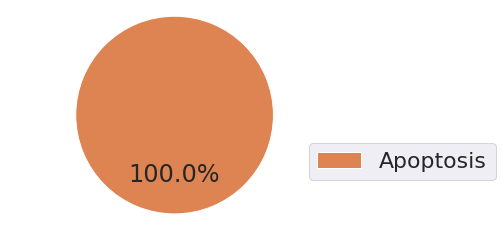

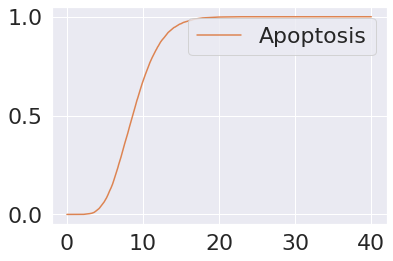

In [21]:
# test TNF=1, FAS=0
# double mutation
# maboss

maboss_doublemutation = model_maboss.copy()
maboss.set_nodes_istate(maboss_doublemutation, ["ATP", "cIAP", "FADD", "TNF"], [0,1])
maboss.set_nodes_istate(maboss_doublemutation, ["FASL"], [1,0])
print(maboss_doublemutation.get_initial_state())

#'NFkB': 0, 'MPT': 0
maboss_doublemutation.mutate('NFkB', 'OFF')
maboss_doublemutation.mutate('MPT', 'OFF')


# Perform the simulation
result = maboss_doublemutation.run()
result.plot_piechart()
result.plot_node_trajectory(until=40)

# The Reduced Model

## Model reduction, importation, visualization

In order to simplify the model, we reduced it using GINsim model reduction functionality.

However, compared with the manually reduced model in the paper, we found a slightly different point, that is, an additional inhibition sign from ```NFkB``` to ```CASP3``` exist in manually reduced model but not the GINsim reduced model.

This could be explained by the principle that model reduction will preserve the dynamical properties.


In [22]:
#load the reduced model

lrg = ginsim.load("https://raw.githubusercontent.com/yitong-sun/BI8040_2020/master/Reduced_model.zginml")

# show the model
ginsim.show(lrg)

Downloading https://raw.githubusercontent.com/yitong-sun/BI8040_2020/master/Reduced_model.zginml

## Attractor analysis, fixpoint display

In [31]:
lqm = ginsim.to_biolqm(lrg)
# Calculate the fixpoints and show them
pert = biolqm.perturbation(lqm, "FADD%1")
fps = biolqm.fixpoints(pert)
print(len(fps), "fixpoints")
tabulate(fps)

13 fixpoints


,FASL,TNF,FADD,RIP1,NFkB,CASP8,ROS,ATP,MPT,MOMP,cIAP,CASP3,NonACD,Apoptosis,Survival
0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0
1,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0
2,0,0,1,0,0,0,1,0,1,1,0,0,1,0,0
3,0,0,1,0,0,1,0,1,0,1,0,1,0,1,0
4,0,1,1,0,0,1,0,1,0,1,0,1,0,1,0
5,0,1,1,0,0,1,1,0,1,1,0,0,1,0,0
6,0,1,1,1,1,0,0,1,0,0,1,0,0,0,1
7,1,0,1,0,0,1,0,1,0,1,0,1,0,1,0
9,1,0,1,0,0,1,1,0,1,1,0,0,1,0,0
11,1,0,1,1,1,0,0,1,0,0,1,0,0,0,1


In [30]:
ginsim.show(lrg, fps[11])

## Analysis of the reduced model with MaBoSS

Wild-type model analyses, first set the inital state TNF=0, FAS=0, getting naive state as the same in master model.

Then with TNF=1, FAS=0, getting all three cell fate reachable, which also similar to that of the master model.


{'FASL': 0, 'TNF': 0, 'TNFR': 0, 'DISC_TNF': 0, 'DISC_FAS': 0, 'FADD': 1, 'RIP1': 0, 'RIP1ub': 0, 'RIP1K': 0, 'IKK': 0, 'NFkB': 0, 'CASP8': 0, 'BAX': 0, 'BCL2': 0, 'ROS': 0, 'ATP': 1, 'MPT': 0, 'MOMP': 0, 'SMAC': 0, 'cIAP': 1, 'Cyt_c': 0, 'XIAP': 0, 'apoptosome': 0, 'CASP3': 0, 'cFLIP': 0, 'NonACD': 0, 'Apoptosis': 0, 'Survival': 0}


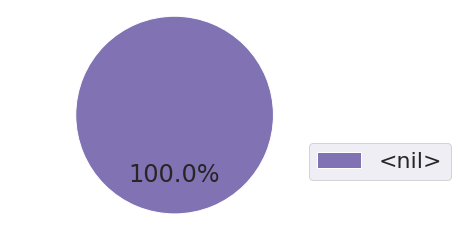

In [25]:
#model_maboss = biolqm.to_maboss(lqm)

model_maboss.update_parameters(discrete_time=0, use_physrandgen=0,
        seed_pseudorandom=100, sample_count=10000,
        max_time=75, time_tick=0.1, thread_count=4,
        statdist_traj_count=100, statdist_cluster_threshold=0.9)

#maboss.wg_set_output(model_maboss)
#maboss.set_output(model_maboss, ["NonACD","Survival", "Apoptosis"])
model_maboss.network.set_output(('Apoptosis','Survival','NonACD'))


## choosing the initial states
# model the different wildtypes (one with TNF=FAS=0 and one with TNF=1 and FAS=0)
maboss_1 = model_maboss.copy()
maboss.set_nodes_istate(maboss_1, ["ATP", "cIAP", "FADD"], [0,1])
maboss.set_nodes_istate(maboss_1, ["TNF", "FASL"], [1,0])

print(maboss_1.get_initial_state())

# Perform the simulation
result = maboss_1.run()
result.plot_piechart()
#result.plot_node_trajectory(until=40)

{'FASL': 0, 'TNF': 1, 'TNFR': 0, 'DISC_TNF': 0, 'DISC_FAS': 0, 'FADD': 1, 'RIP1': 0, 'RIP1ub': 0, 'RIP1K': 0, 'IKK': 0, 'NFkB': 0, 'CASP8': 0, 'BAX': 0, 'BCL2': 0, 'ROS': 0, 'ATP': 1, 'MPT': 0, 'MOMP': 0, 'SMAC': 0, 'cIAP': 1, 'Cyt_c': 0, 'XIAP': 0, 'apoptosome': 0, 'CASP3': 0, 'cFLIP': 0, 'NonACD': 0, 'Apoptosis': 0, 'Survival': 0}


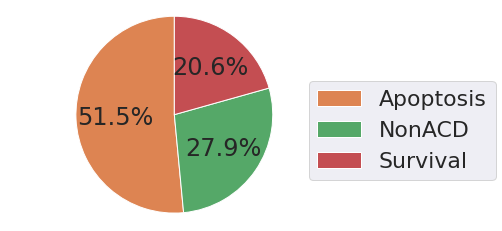

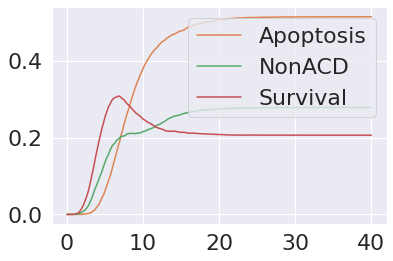

In [26]:
# test TNF=1, FAS=0, wildtype

maboss_2 = model_maboss.copy()
maboss.set_nodes_istate(maboss_2, ["ATP", "cIAP", "FADD", "TNF"], [0,1])
maboss.set_nodes_istate(maboss_2, ["FASL"], [1,0])
print(maboss_2.get_initial_state())

# Perform the simulation
result = maboss_2.run()
result.plot_piechart()
result.plot_node_trajectory(until=40)

# Conclusion:


Not only dedicate to reproduce the results from the literature, also test a pair of double mutation predicted on the master model.

# Future steps:

- Study cross-talks between these pathways.
- Model extension by manual curation and omics data analysis, then study the model dynamical behavior.
- Test model performance in different cell lines.